In [2]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import torch
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# GraphSAGE Layer implementation
class GraphSAGELayer(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super(GraphSAGELayer, self).__init__()
        self.normalize = normalize
        self.weight = nn.Linear(in_channels * 2, out_channels, bias=True)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight.weight)
        if self.weight.bias is not None:
            nn.init.zeros_(self.weight.bias)

    def forward(self, x, edge_index):
        # Aggregate neighbor features
        row, col = edge_index
        neighbor_features = x[col]
        neighbor_mean = scatter_mean(neighbor_features, row, dim=0, dim_size=x.size(0))
        
        # Concatenate self features with aggregated neighbor features
        out = torch.cat([x, neighbor_mean], dim=1)
        out = self.weight(out)
        
        if self.normalize:
            out = F.normalize(out, p=2, dim=1)
        
        return out

# Modified Generator with GraphSAGE layers
class GraphSAGEGenerator(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size, num_layers=2):
        super(GraphSAGEGenerator, self).__init__()
        
        self.num_layers = num_layers
        self.fc_z = nn.Linear(latent_size, hidden_size)
        
        # GraphSAGE layers
        self.conv_layers = nn.ModuleList()
        for i in range(num_layers):
            in_channels = hidden_size if i == 0 else hidden_size
            self.conv_layers.append(GraphSAGELayer(in_channels, hidden_size))
        
        # Output layer
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, z, edge_index):
        # Transform latent vector
        x = self.fc_z(z)
        x = F.relu(x)
        
        # Apply GraphSAGE layers
        for i in range(self.num_layers):
            x = self.conv_layers[i](x, edge_index)
            x = F.relu(x)
        
        # Generate final output
        x = self.fc_out(x)
        return x

# Modified Discriminator with GraphSAGE layers
class GraphSAGEDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(GraphSAGEDiscriminator, self).__init__()
        
        self.num_layers = num_layers
        
        # GraphSAGE layers
        self.conv_layers = nn.ModuleList()
        first_layer = GraphSAGELayer(input_size, hidden_size)
        self.conv_layers.append(first_layer)
        
        for i in range(num_layers - 1):
            self.conv_layers.append(GraphSAGELayer(hidden_size, hidden_size))
        
        # Final classification layer
        self.fc_out = nn.Linear(hidden_size, 1)

    def forward(self, x, edge_index):
        # Apply GraphSAGE layers
        for i in range(self.num_layers):
            x = self.conv_layers[i](x, edge_index)
            x = F.relu(x)
            
        # Final classification
        x = self.fc_out(x)
        return x
    
# Add the missing Classifier class
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, 2)  # 2 classes: fraud and non-fraud
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Helper function for GraphSAGE
def scatter_mean(src, index, dim=-1, dim_size=None):
    if dim_size is None:
        dim_size = index.max().item() + 1
    
    out = torch.zeros((dim_size, src.size(-1)), device=src.device)
    count = torch.zeros(dim_size, device=src.device)
    
    index_expanded = index.unsqueeze(-1).expand(-1, src.size(-1))
    out.scatter_add_(0, index_expanded, src)
    count.scatter_add_(0, index, torch.ones_like(index, dtype=torch.float))
    
    count[count == 0] = 1  # Avoid division by zero
    count = count.unsqueeze(-1)
    
    return out / count

# Data preprocessing functions (same as before)
def df_label_encoder(df, columns):
    le = preprocessing.LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

def preprocess(df):
    df = df_label_encoder(df, ['merchant', 'category', 'city', 'state', 'job'])
    df['amt'] = (df['amt'] - df['amt'].min()) / (df['amt'].max() - df['amt'].min())
    df['node_from'] = df['cc_num'].astype(str)
    df['node_to'] = df['merchant'].astype(str)
    df = df.sort_values(by=['node_from'])
    node_list = pd.concat([df['node_from'], df['node_to']]).unique()
    return df, node_list

def create_graph_data(df, node_list):
    node_map = {node: idx for idx, node in enumerate(node_list)}
    edge_index = np.array([
        [node_map[from_node], node_map[to_node]] 
        for from_node, to_node in zip(df['node_from'], df['node_to'])
    ], dtype=np.int64).T
    
    node_features = torch.tensor(df[['amt', 'category', 'city', 'state']].values, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    labels = torch.tensor(df['is_fraud'].values, dtype=torch.long)
    
    return node_features, edge_index, labels

# Training parameters
def train_wgan_graphsage(generator, discriminator, node_features, edge_index, labels, 
                        num_epochs=16, batch_size=32, critic_iterations=5):
    
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.9))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.9))
    
    real_data = node_features[labels == 1]
    target_minority_class = torch.sum(labels == 0)
    
    for epoch in range(num_epochs):
        # Train Discriminator
        for _ in range(critic_iterations):
            optimizer_d.zero_grad()
            
            # Real data
            d_real = discriminator(real_data, edge_index)
            
            # Generate fake data
            z = torch.randn(real_data.size(0), latent_size)
            fake_data = generator(z, edge_index)
            d_fake = discriminator(fake_data.detach(), edge_index)
            
            # Compute WGAN loss
            loss_d = -torch.mean(d_real) + torch.mean(d_fake)
            loss_d.backward()
            optimizer_d.step()
            
            # Clip weights
            for p in discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)
        
        # Train Generator
        optimizer_g.zero_grad()
        fake_data = generator(torch.randn(real_data.size(0), latent_size), edge_index)
        loss_g = -torch.mean(discriminator(fake_data, edge_index))
        loss_g.backward()
        optimizer_g.step()
        
        if epoch % 1 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}')
    
    return generator, discriminator

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    df = pd.read_csv('creditcard/fraudTrain.csv')
    df, node_list = preprocess(df)
    node_features, edge_index, labels = create_graph_data(df, node_list)
    
    # Model parameters
    input_size = node_features.shape[1]
    hidden_size = 128
    latent_size = 64
    num_layers = 2
    
    # Initialize models
    generator = GraphSAGEGenerator(latent_size, hidden_size, input_size, num_layers)
    discriminator = GraphSAGEDiscriminator(input_size, hidden_size, num_layers)
    
    # Train models
    generator, discriminator = train_wgan_graphsage(
        generator, discriminator, node_features, edge_index, labels
    )
    
    # Generate samples
    num_samples = torch.sum(labels == 0) - torch.sum(labels == 1)
    z = torch.randn(num_samples, latent_size)
    with torch.no_grad():  # Add no_grad here for generation
        generated_samples = generator(z, edge_index)
    
    # Combine real and generated data
    augmented_features = torch.cat([node_features, generated_samples], dim=0)
    augmented_labels = torch.cat([
        labels, 
        torch.ones(num_samples, dtype=torch.long)
    ])
    
    # Split data for classifier training
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(
        augmented_features.detach(),  # Add detach here
        augmented_labels, 
        test_size=0.2, 
        random_state=42
    )
    
    # Train and evaluate classifier
    classifier = Classifier(input_size, hidden_size)
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop for classifier
    num_epochs = 30
    for epoch in range(num_epochs):
        classifier.train()
        
        # Forward pass
        outputs = classifier(x_train)
        loss = criterion(outputs, y_train)
        
        # Backward pass
        optimizer.zero_grad()  # Move zero_grad before loss calculation
        loss.backward()
        optimizer.step()
        
        # Evaluation phase
        if epoch % 5 == 0:
            classifier.eval()
            with torch.no_grad():  # Add no_grad for evaluation
                test_outputs = classifier(x_test)
                test_loss = criterion(test_outputs, y_test)
                accuracy = accuracy_score(
                    y_test.cpu().numpy(),
                    test_outputs.argmax(dim=1).cpu().numpy()
                )
                print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Test Acc: {accuracy:.4f}')
    
    # Final evaluation
    classifier.eval()
    with torch.no_grad():
        final_outputs = classifier(x_test)
        y_pred = final_outputs.argmax(dim=1)
        final_accuracy = accuracy_score(y_test.cpu().numpy(), y_pred.cpu().numpy())
        print(f'Final Test Accuracy: {final_accuracy:.4f}')

Epoch [0/16], Loss D: -0.0285, Loss G: 0.0072
Epoch [1/16], Loss D: -0.0706, Loss G: 0.0331
Epoch [2/16], Loss D: -0.1023, Loss G: 0.0468
Epoch [3/16], Loss D: -0.1218, Loss G: 0.0550
Epoch [4/16], Loss D: -0.1335, Loss G: 0.0588
Epoch [5/16], Loss D: -0.1414, Loss G: 0.0608
Epoch [6/16], Loss D: -0.1475, Loss G: 0.0625
Epoch [7/16], Loss D: -0.1510, Loss G: 0.0640
Epoch [8/16], Loss D: -0.1531, Loss G: 0.0648
Epoch [9/16], Loss D: -0.1546, Loss G: 0.0653
Epoch [10/16], Loss D: -0.1556, Loss G: 0.0657
Epoch [11/16], Loss D: -0.1564, Loss G: 0.0660
Epoch [12/16], Loss D: -0.1570, Loss G: 0.0663
Epoch [13/16], Loss D: -0.1576, Loss G: 0.0666
Epoch [14/16], Loss D: -0.1581, Loss G: 0.0670
Epoch [15/16], Loss D: -0.1585, Loss G: 0.0671
Epoch 0, Loss: 8.0163, Test Acc: 0.9817
Epoch 5, Loss: 0.5159, Test Acc: 0.9971
Epoch 10, Loss: 0.5786, Test Acc: 0.9971
Epoch 15, Loss: 0.6062, Test Acc: 0.9971
Epoch 20, Loss: 0.5930, Test Acc: 0.9971
Epoch 25, Loss: 0.5672, Test Acc: 0.9971
Final Test Acc

Using device: cuda
Loading and preprocessing data...
Initializing models...
Training WGAN-GP...
Epoch [0/16], Loss D: -0.0245, Loss G: 0.0110
Epoch [1/16], Loss D: -0.0627, Loss G: 0.0324
Epoch [2/16], Loss D: -0.0952, Loss G: 0.0470
Epoch [3/16], Loss D: -0.1173, Loss G: 0.0562
Epoch [4/16], Loss D: -0.1322, Loss G: 0.0609
Epoch [5/16], Loss D: -0.1423, Loss G: 0.0638
Epoch [6/16], Loss D: -0.1479, Loss G: 0.0655
Epoch [7/16], Loss D: -0.1518, Loss G: 0.0666
Epoch [8/16], Loss D: -0.1543, Loss G: 0.0676
Epoch [9/16], Loss D: -0.1558, Loss G: 0.0684
Epoch [10/16], Loss D: -0.1567, Loss G: 0.0689
Epoch [11/16], Loss D: -0.1573, Loss G: 0.0693
Epoch [12/16], Loss D: -0.1578, Loss G: 0.0696
Epoch [13/16], Loss D: -0.1582, Loss G: 0.0700
Epoch [14/16], Loss D: -0.1586, Loss G: 0.0703
Epoch [15/16], Loss D: -0.1590, Loss G: 0.0705
Generating synthetic samples...
Training classifier...
Epoch 0, Loss: 0.6851, Test Acc: 0.9971
Epoch 5, Loss: 0.5689, Test Acc: 0.9971
Epoch 10, Loss: 0.4456, Tes

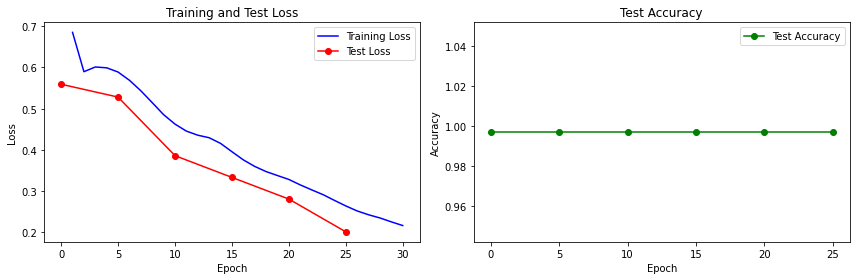


Final Evaluation:


In [10]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import torch
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Metrics tracking class
class MetricsTracker:
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.test_accuracies = []
        self.test_epochs = []  # To track epochs where test metrics are recorded
    
    def update(self, epoch, train_loss, test_loss=None, test_accuracy=None):
        self.train_losses.append(train_loss)
        if test_loss is not None:
            self.test_losses.append(test_loss)
            self.test_accuracies.append(test_accuracy)
            self.test_epochs.append(epoch)
    
    def plot_metrics(self):
        plt.figure(figsize=(12, 4))
        
        # Training and Test Loss plot
        plt.subplot(1, 2, 1)
        train_epochs = range(1, len(self.train_losses) + 1)
        plt.plot(train_epochs, self.train_losses, 'b-', label='Training Loss')
        
        if self.test_losses:
            plt.plot(self.test_epochs, self.test_losses, 'r-', marker='o', label='Test Loss')
        
        plt.title('Training and Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Test Accuracy plot
        if self.test_accuracies:
            plt.subplot(1, 2, 2)
            plt.plot(self.test_epochs, self.test_accuracies, 'g-', marker='o', label='Test Accuracy')
            plt.title('Test Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
        
        plt.tight_layout()
        plt.show()

# Helper function for GraphSAGE
def scatter_mean(src, index, dim=-1, dim_size=None):
    if dim_size is None:
        dim_size = index.max().item() + 1
    
    out = torch.zeros((dim_size, src.size(-1)), device=src.device)
    count = torch.zeros(dim_size, device=src.device)
    
    index_expanded = index.unsqueeze(-1).expand(-1, src.size(-1))
    out.scatter_add_(0, index_expanded, src)
    count.scatter_add_(0, index, torch.ones_like(index, dtype=torch.float))
    
    count[count == 0] = 1
    count = count.unsqueeze(-1)
    
    return out / count

# GraphSAGE Layer implementation
class GraphSAGELayer(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super(GraphSAGELayer, self).__init__()
        self.normalize = normalize
        self.weight = nn.Linear(in_channels * 2, out_channels, bias=True)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight.weight)
        if self.weight.bias is not None:
            nn.init.zeros_(self.weight.bias)

    def forward(self, x, edge_index):
        row, col = edge_index
        neighbor_features = x[col]
        neighbor_mean = scatter_mean(neighbor_features, row, dim=0, dim_size=x.size(0))
        
        out = torch.cat([x, neighbor_mean], dim=1)
        out = self.weight(out)
        
        if self.normalize:
            out = F.normalize(out, p=2, dim=1)
        
        return out

# Generator with GraphSAGE layers
class GraphSAGEGenerator(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size, num_layers=2):
        super(GraphSAGEGenerator, self).__init__()
        
        self.num_layers = num_layers
        self.fc_z = nn.Linear(latent_size, hidden_size)
        
        self.conv_layers = nn.ModuleList()
        for i in range(num_layers):
            in_channels = hidden_size if i == 0 else hidden_size
            self.conv_layers.append(GraphSAGELayer(in_channels, hidden_size))
        
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, z, edge_index):
        x = self.fc_z(z)
        x = F.relu(x)
        
        for i in range(self.num_layers):
            x = self.conv_layers[i](x, edge_index)
            x = F.relu(x)
        
        x = self.fc_out(x)
        return x

# Discriminator with GraphSAGE layers
class GraphSAGEDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(GraphSAGEDiscriminator, self).__init__()
        
        self.num_layers = num_layers
        
        self.conv_layers = nn.ModuleList()
        first_layer = GraphSAGELayer(input_size, hidden_size)
        self.conv_layers.append(first_layer)
        
        for i in range(num_layers - 1):
            self.conv_layers.append(GraphSAGELayer(hidden_size, hidden_size))
        
        self.fc_out = nn.Linear(hidden_size, 1)

    def forward(self, x, edge_index):
        for i in range(self.num_layers):
            x = self.conv_layers[i](x, edge_index)
            x = F.relu(x)
            
        x = self.fc_out(x)
        return x

# Classifier for final prediction
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, 2)  # binary classification
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Data preprocessing functions
def df_label_encoder(df, columns):
    le = preprocessing.LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

def preprocess(df):
    df = df_label_encoder(df, ['merchant', 'category', 'city', 'state', 'job'])
    df['amt'] = (df['amt'] - df['amt'].min()) / (df['amt'].max() - df['amt'].min())
    df['node_from'] = df['cc_num'].astype(str)
    df['node_to'] = df['merchant'].astype(str)
    df = df.sort_values(by=['node_from'])
    node_list = pd.concat([df['node_from'], df['node_to']]).unique()
    return df, node_list

def create_graph_data(df, node_list):
    node_map = {node: idx for idx, node in enumerate(node_list)}
    edge_index = np.array([[node_map[from_node], node_map[to_node]] 
                          for from_node, to_node in zip(df['node_from'], df['node_to'])], 
                         dtype=np.int64).T
    
    node_features = torch.tensor(df[['amt', 'category', 'city', 'state']].values, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    labels = torch.tensor(df['is_fraud'].values, dtype=torch.long)
    
    return node_features, edge_index, labels

# WGAN training function
def train_wgan_graphsage(generator, discriminator, node_features, edge_index, labels, 
                        num_epochs=16, batch_size=32, critic_iterations=5):
    
    device = node_features.device  # Get the device from input tensors
    
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.9))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.9))
    
    real_data = node_features[labels == 1]
    latent_size = generator.fc_z.in_features  # Get latent size from generator's first layer
    
    for epoch in range(num_epochs):
        # Train Discriminator
        for _ in range(critic_iterations):
            optimizer_d.zero_grad()
            
            d_real = discriminator(real_data, edge_index)
            
            # Generate noise on the same device as other tensors
            z = torch.randn(real_data.size(0), latent_size, device=device)
            fake_data = generator(z, edge_index)
            d_fake = discriminator(fake_data.detach(), edge_index)
            
            loss_d = -torch.mean(d_real) + torch.mean(d_fake)
            loss_d.backward()
            optimizer_d.step()
            
            # Clip discriminator weights
            for p in discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)
        
        # Train Generator
        optimizer_g.zero_grad()
        z = torch.randn(real_data.size(0), latent_size, device=device)  # Generate noise on correct device
        fake_data = generator(z, edge_index)
        loss_g = -torch.mean(discriminator(fake_data, edge_index))
        loss_g.backward()
        optimizer_g.step()
        
        if epoch % 1 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}')
    
    return generator, discriminator

def generate_synthetic_samples(generator, num_samples, edge_index, device):
    latent_size = generator.fc_z.in_features
    z = torch.randn(num_samples, latent_size, device=device)
    with torch.no_grad():
        generated_samples = generator(z, edge_index)
    return generated_samples

# Main execution
if __name__ == "__main__":
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load and preprocess data
    print("Loading and preprocessing data...")
    df = pd.read_csv('creditcard/fraudTrain.csv')
    df, node_list = preprocess(df)
    node_features, edge_index, labels = create_graph_data(df, node_list)
    
    # Move data to device
    node_features = node_features.to(device)
    edge_index = edge_index.to(device)
    labels = labels.to(device)
    
    # Model parameters
    input_size = node_features.shape[1]
    hidden_size = 128
    latent_size = 64
    num_layers = 2
    
    # Initialize models
    print("Initializing models...")
    generator = GraphSAGEGenerator(latent_size, hidden_size, input_size, num_layers).to(device)
    discriminator = GraphSAGEDiscriminator(input_size, hidden_size, num_layers).to(device)
    
    # Train WGAN-GP
    print("Training WGAN-GP...")
    generator, discriminator = train_wgan_graphsage(
        generator, discriminator, node_features, edge_index, labels
    )
    
    # Generate synthetic samples
    print("Generating synthetic samples...")
    num_samples = torch.sum(labels == 0) - torch.sum(labels == 1)
    generated_samples = generate_synthetic_samples(generator, num_samples, edge_index, device)
    
    # Combine real and generated data
    augmented_features = torch.cat([node_features, generated_samples], dim=0)
    augmented_labels = torch.cat([
        labels, 
        torch.ones(num_samples, dtype=torch.long, device=device)
    ])
    
    # Split data for classifier training
    x_train, x_test, y_train, y_test = train_test_split(
        augmented_features.cpu().numpy(),
        augmented_labels.cpu().numpy(), 
        test_size=0.2, 
        random_state=42
    )
    
    # Convert split data to tensors and move to device
    x_train = torch.tensor(x_train, dtype=torch.float).to(device)
    x_test = torch.tensor(x_test, dtype=torch.float).to(device)
    y_train = torch.tensor(y_train, dtype=torch.long).to(device)
    y_test = torch.tensor(y_test, dtype=torch.long).to(device)
    
    # Initialize classifier and training components
    print("Training classifier...")
    classifier = Classifier(input_size, hidden_size).to(device)
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    metrics_tracker = MetricsTracker()
    
    # Training loop for classifier
    num_epochs = 30
    for epoch in range(num_epochs):
        classifier.train()
        
        # Forward pass
        outputs = classifier(x_train)
        loss = criterion(outputs, y_train)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Evaluation phase
        if epoch % 5 == 0:
            classifier.eval()
            with torch.no_grad():
                test_outputs = classifier(x_test)
                test_loss = criterion(test_outputs, y_test)
                accuracy = accuracy_score(
                    y_test.cpu().numpy(),
                    test_outputs.argmax(dim=1).cpu().numpy()
                )
                metrics_tracker.update(
                    epoch=epoch,
                    train_loss=loss.item(),
                    test_loss=test_loss.item(),
                    test_accuracy=accuracy
                )
                print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Test Acc: {accuracy:.4f}')
        else:
            metrics_tracker.update(epoch=epoch, train_loss=loss.item())
    
    # Plot training metrics
    metrics_tracker.plot_metrics()
    
    # Final evaluation
    print("\nFinal Evaluation:")
    classifier.eval()
    with torch.no_grad():
        final_outputs = classifier(x_test)
        y_pred = final_outputs.argmax(dim=1)
        
        # Calculate metrics
        final_accuracy = accuracy_score(y_test.cpu().numpy(), y_pred.cpu().numpy())

In [2]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import torch
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score, confusion_matrix,
    precision_score, recall_score, matthews_corrcoef, r2_score,
    f1_score
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Enhanced Metrics tracking class
class MetricsTracker:
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.test_accuracies = []
        self.test_precisions = []
        self.test_recalls = []
        self.test_f1s = []
        self.test_mccs = []
        self.test_r2s = []
        self.test_roc_aucs = []
        self.test_epochs = []
    
    def update(self, epoch, train_loss, test_loss=None, metrics=None):
        self.train_losses.append(train_loss)
        if test_loss is not None and metrics is not None:
            self.test_losses.append(test_loss)
            self.test_accuracies.append(metrics['accuracy'])
            self.test_precisions.append(metrics['precision'])
            self.test_recalls.append(metrics['recall'])
            self.test_f1s.append(metrics['f1'])
            self.test_mccs.append(metrics['mcc'])
            self.test_r2s.append(metrics['r2'])
            self.test_roc_aucs.append(metrics['roc_auc'])
            self.test_epochs.append(epoch)
    
    def plot_metrics(self):
        plt.figure(figsize=(20, 12))
        
        # Training and Test Loss plot
        plt.subplot(2, 3, 1)
        train_epochs = range(1, len(self.train_losses) + 1)
        plt.plot(train_epochs, self.train_losses, 'b-', label='Training Loss')
        if self.test_losses:
            plt.plot(self.test_epochs, self.test_losses, 'r-', marker='o', label='Test Loss')
        plt.title('Training and Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Accuracy, Precision, Recall plot
        plt.subplot(2, 3, 2)
        if self.test_accuracies:
            plt.plot(self.test_epochs, self.test_accuracies, 'g-', marker='o', label='Accuracy')
            plt.plot(self.test_epochs, self.test_precisions, 'b-', marker='o', label='Precision')
            plt.plot(self.test_epochs, self.test_recalls, 'r-', marker='o', label='Recall')
            plt.plot(self.test_epochs, self.test_f1s, 'y-', marker='o', label='F1')
        plt.title('Classification Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        
        # MCC and R2 plot
        plt.subplot(2, 3, 3)
        if self.test_mccs:
            plt.plot(self.test_epochs, self.test_mccs, 'p-', marker='o', label='MCC')
            plt.plot(self.test_epochs, self.test_r2s, 'y-', marker='o', label='R2')
        plt.title('MCC and R2 Scores')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        
        # ROC AUC plot
        plt.subplot(2, 3, 4)
        if self.test_roc_aucs:
            plt.plot(self.test_epochs, self.test_roc_aucs, 'm-', marker='o', label='ROC AUC')
        plt.title('ROC AUC Score')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

def calculate_metrics(y_true, y_pred, y_pred_proba=None):
    """
    Calculate comprehensive metrics for model evaluation
    """
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'mcc': matthews_corrcoef(y_true, y_pred),
        'r2': r2_score(y_true, y_pred)
    }
    
    # Calculate ROC AUC if probabilities are provided
    if y_pred_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba[:, 1])
    else:
        metrics['roc_auc'] = 0.0
    
    return metrics

def plot_roc_curve(y_true, y_pred_proba):
    """
    Plot ROC curve
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
    roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes=['Non-Fraud', 'Fraud']):
    """
    Plot confusion matrix with percentages and counts
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotation text with both count and percentage
    annot = np.empty_like(cm, dtype=str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'
    
    # Plot heatmap
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix\nCount and (Percentage)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Model architectures remain the same as before
class GraphSAGELayer(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super(GraphSAGELayer, self).__init__()
        self.normalize = normalize
        self.weight = nn.Linear(in_channels * 2, out_channels, bias=True)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight.weight)
        if self.weight.bias is not None:
            nn.init.zeros_(self.weight.bias)

    def forward(self, x, edge_index):
        row, col = edge_index
        neighbor_features = x[col]
        
        # Calculate mean of neighbor features
        neighbor_mean = scatter_mean(neighbor_features, row, dim=0, dim_size=x.size(0))
        
        # Concatenate node's own features with neighbor features
        out = torch.cat([x, neighbor_mean], dim=1)
        out = self.weight(out)
        
        if self.normalize:
            out = F.normalize(out, p=2, dim=1)
        
        return out

def scatter_mean(src, index, dim=-1, dim_size=None):
    if dim_size is None:
        dim_size = index.max().item() + 1
    
    out = torch.zeros((dim_size, src.size(-1)), device=src.device)
    count = torch.zeros(dim_size, device=src.device)
    
    index_expanded = index.unsqueeze(-1).expand(-1, src.size(-1))
    out.scatter_add_(0, index_expanded, src)
    count.scatter_add_(0, index, torch.ones_like(index, dtype=torch.float))
    
    count[count == 0] = 1
    count = count.unsqueeze(-1)
    
    return out / count

class GraphSAGEGenerator(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size, num_layers=2):
        super(GraphSAGEGenerator, self).__init__()
        
        self.num_layers = num_layers
        self.fc_z = nn.Linear(latent_size, hidden_size)
        
        self.conv_layers = nn.ModuleList()
        for i in range(num_layers):
            in_channels = hidden_size if i == 0 else hidden_size
            self.conv_layers.append(GraphSAGELayer(in_channels, hidden_size))
        
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, z, edge_index):
        x = self.fc_z(z)
        x = F.relu(x)
        
        for i in range(self.num_layers):
            x = self.conv_layers[i](x, edge_index)
            x = F.relu(x)
        
        x = self.fc_out(x)
        return x

class GraphSAGEDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(GraphSAGEDiscriminator, self).__init__()
        
        self.num_layers = num_layers
        
        self.conv_layers = nn.ModuleList()
        first_layer = GraphSAGELayer(input_size, hidden_size)
        self.conv_layers.append(first_layer)
        
        for i in range(num_layers - 1):
            self.conv_layers.append(GraphSAGELayer(hidden_size, hidden_size))
        
        self.fc_out = nn.Linear(hidden_size, 1)

    def forward(self, x, edge_index):
        for i in range(self.num_layers):
            x = self.conv_layers[i](x, edge_index)
            x = F.relu(x)
            
        x = self.fc_out(x)
        return x

class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, 2)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Data preprocessing functions
def df_label_encoder(df, columns):
    le = preprocessing.LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

def preprocess(df):
    df = df_label_encoder(df, ['merchant', 'category', 'city', 'state', 'job'])
    df['amt'] = (df['amt'] - df['amt'].min()) / (df['amt'].max() - df['amt'].min())
    df['node_from'] = df['cc_num'].astype(str)
    df['node_to'] = df['merchant'].astype(str)
    df = df.sort_values(by=['node_from'])
    node_list = pd.concat([df['node_from'], df['node_to']]).unique()
    return df, node_list

def create_graph_data(df, node_list):
    node_map = {node: idx for idx, node in enumerate(node_list)}
    edge_index = np.array([[node_map[from_node], node_map[to_node]] 
                          for from_node, to_node in zip(df['node_from'], df['node_to'])], 
                         dtype=np.int64).T
    
    node_features = torch.tensor(df[['amt', 'category', 'city', 'state']].values, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    labels = torch.tensor(df['is_fraud'].values, dtype=torch.long)
    
    return node_features, edge_index, labels

def train_wgan_graphsage(generator, discriminator, node_features, edge_index, labels, 
                        num_epochs=16, batch_size=32, critic_iterations=5):
    device = node_features.device
    
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.9))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.9))
    
    real_data = node_features[labels == 1]
    latent_size = generator.fc_z.in_features
    
    for epoch in range(num_epochs):
        # Train Discriminator
        for _ in range(critic_iterations):
            optimizer_d.zero_grad()
            
            d_real = discriminator(real_data, edge_index)
            z = torch.randn(real_data.size(0), latent_size, device=device)
            fake_data = generator(z, edge_index)
            d_fake = discriminator(fake_data.detach(), edge_index)
            
            loss_d = -torch.mean(d_real) + torch.mean(d_fake)
            loss_d.backward()
            optimizer_d.step()
            
            # Clip discriminator weights
            for p in discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)
        
        # Train Generator
        optimizer_g.zero_grad()
        z = torch.randn(real_data.size(0), latent_size, device=device)
        fake_data = generator(z, edge_index)
        loss_g = -torch.mean(discriminator(fake_data, edge_index))
        loss_g.backward()

In [3]:
def train_wgan_graphsage(generator, discriminator, node_features, edge_index, labels, 
                        num_epochs=16, batch_size=32, critic_iterations=5, tracker=None):
    device = node_features.device
    
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.9))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.9))
    
    real_data = node_features[labels == 1]
    latent_size = generator.fc_z.in_features

    for epoch in range(num_epochs):
        # Training loop for Discriminator
        for _ in range(critic_iterations):
            optimizer_d.zero_grad()
            
            # Real data predictions
            d_real = discriminator(real_data, edge_index)
            z = torch.randn(real_data.size(0), latent_size, device=device)
            
            # Generate fake data
            fake_data = generator(z, edge_index)
            d_fake = discriminator(fake_data.detach(), edge_index)
            
            # Discriminator loss
            loss_d = -torch.mean(d_real) + torch.mean(d_fake)
            loss_d.backward()
            optimizer_d.step()
            
            # Clip discriminator weights
            for p in discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)
        
        # Training loop for Generator
        optimizer_g.zero_grad()
        z = torch.randn(real_data.size(0), latent_size, device=device)
        fake_data = generator(z, edge_index)
        loss_g = -torch.mean(discriminator(fake_data, edge_index))
        loss_g.backward()
        optimizer_g.step()
        
        # Logging losses
        print(f"Epoch {epoch + 1}/{num_epochs} - Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")
        
        if tracker:
            # Optionally track metrics if a tracker is provided
            tracker.update(epoch, train_loss=loss_d.item(), test_loss=loss_g.item())

    # Optionally, plot the metrics after training
    if tracker:
        tracker.plot_metrics()


In [4]:
def evaluate_final_metrics(generator, classifier, node_features, edge_index, labels, tracker=None):
    device = node_features.device
    
    # Split data into real and generated samples
    real_data = node_features[labels == 1]
    latent_size = generator.fc_z.in_features
    z = torch.randn(real_data.size(0), latent_size, device=device)
    
    # Generate synthetic fraud samples
    generated_data = generator(z, edge_index).detach()
    
    # Combine real and generated data for evaluation
    combined_data = torch.cat([real_data, generated_data], dim=0)
    combined_labels = torch.cat([torch.ones(real_data.size(0), dtype=torch.long, device=device),
                                 torch.zeros(generated_data.size(0), dtype=torch.long, device=device)])
    
    # Make predictions using the classifier
    classifier.eval()
    with torch.no_grad():
        outputs = classifier(combined_data)
        _, preds = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1).cpu().numpy()

    # Calculate metrics
    metrics = calculate_metrics(combined_labels.cpu(), preds.cpu(), probs)
    
    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"MCC: {metrics['mcc']:.4f}")
    print(f"R2 Score: {metrics['r2']:.4f}")
    print(f"ROC AUC: {metrics['roc_auc']:.4f}")
    
    # Optionally update tracker with final metrics
    if tracker:
        tracker.update(epoch='Final', train_loss=0, metrics=metrics)
        tracker.plot_metrics()


In [5]:
# Assume 'classifier' is a trained instance of the Classifier class
evaluate_final_metrics(generator, classifier, node_features, edge_index, labels, tracker=tracker)


NameError: name 'generator' is not defined